# Linear LFM

Replication of the paper by [Lawrence et al., 2006.](https://papers.nips.cc/paper/3119-modelling-transcriptional-regulation-using-gaussian-processes.pdf)

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

### Probesets

The original paper restricted their interest to 5 known targets of p53:

| Target       | Probeset     | Aliases    |
| :------------- | :----------: | :----------- |
| DDB2 |  203409_at    | |
| p21   | 202284_s_at | p21CIP1, CDKN1A |
| SESN1/hPA26   | 218346_s_at |  |
| BIK   | 205780_at |  |
| TNFRSF10b   | 209294_x_at, 209295_at, 210405_x_at |  |

In [1]:
import torch

from lafomo.exact import AnalyticalLFM, Trainer
from lafomo.datasets import P53Data
from lafomo.plot import Plotter

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data/')
model = AnalyticalLFM(dataset, dataset.variance.reshape(-1))
optimizer = torch.optim.Adam(model.parameters(), lr=0.07)
trainer = Trainer(model, optimizer)
plotter = Plotter(model, dataset.gene_names)

In [5]:
trainer.train(epochs=100)

Iter 1/100 - Loss: 0.374   lengthscale: 1.066   noise: 0.003
Iter 11/100 - Loss: 0.332   lengthscale: 1.100   noise: 0.002
Iter 21/100 - Loss: 0.304   lengthscale: 1.174   noise: 0.002
Iter 31/100 - Loss: 0.286   lengthscale: 1.151   noise: 0.001
Iter 41/100 - Loss: 0.273   lengthscale: 1.142   noise: 0.001
Iter 51/100 - Loss: 0.264   lengthscale: 1.161   noise: 0.001
Iter 61/100 - Loss: 0.257   lengthscale: 1.165   noise: 0.001
Iter 71/100 - Loss: 0.251   lengthscale: 1.164   noise: 0.000
Iter 81/100 - Loss: 0.247   lengthscale: 1.169   noise: 0.000
Iter 91/100 - Loss: 0.245   lengthscale: 1.170   noise: 0.000


torch.Size([1, 80, 80]) tensor(-0.0653, dtype=torch.float64, grad_fn=<MinBackward1>)
torch.Size([1, 80]) torch.Size([1, 80, 80])
tensor(0.0753, dtype=torch.float64, grad_fn=<MinBackward1>)


RuntimeError: cholesky_cpu: For batch 0: U(20,20) is zero, singular U.

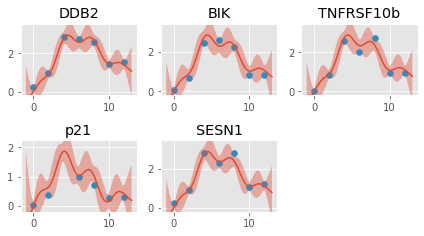

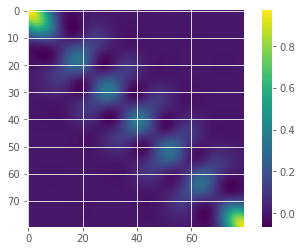

In [6]:
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float64)

plotter.plot_outputs(t_predict, t_scatter=dataset.t_observed, y_scatter=dataset.m_observed)

plotter.plot_latents(t_predict, ylim=(-2, 3.2), num_samples=1)

plotter.plot_kinetics()

In [ ]:
from matplotlib import pyplot as plt

Kxx = model.covar_module(model.train_t, model.train_t).evaluate()

plt.figure()
plt.imshow(Kxx.detach())
plt.axis('off')

Kxf = model.covar_module.K_xf(model.train_t, t_predict).type(torch.float64)

Kfx = torch.transpose(Kxf, 0, 1)
L = torch.cholesky(Kxx)

KxxKxf = torch.cholesky_solve(Kxf, L, upper=False)

# K_inv = torch.inverse(Kxx)

print(KxxKxf)
# KfxKxx = torch.matmul(torch.transpose(Kxf, 0, 1), K_inv)
# print(KfxKxx)
# mu = torch.matmul(KfxKxx, model.train_y).view(-1)
# plt.figure()
# plt.plot(mu.detach())

Kff = model.covar_module.K_ff(t_predict, t_predict)  # (100, 500)
plt.figure()
plt.imshow(Kff.detach())
plt.colorbar()
var = Kff - torch.matmul(Kfx, KxxKxf)
print(torch.diagonal(torch.matmul(Kfx, KxxKxf)).max())
print(torch.diagonal(var).min())
plt.figure()
plt.imshow(var.detach())
plt.colorbar()

plt.figure()
kfxf = torch.matmul(Kfx, KxxKxf)
print(kfxf)
plt.imshow(kfxf.detach())
plt.colorbar()


